In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/insurance/insurance.csv


# 1-) Leitura dos Dados

In [2]:
medical_df = pd.read_csv("../input/insurance/insurance.csv")
print(f"Medical dataframe shape:{medical_df.shape}")
medical_df.head()

Medical dataframe shape:(1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


# 2-) EDA

In [4]:
# Visão geral dos dados
medical_df.describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


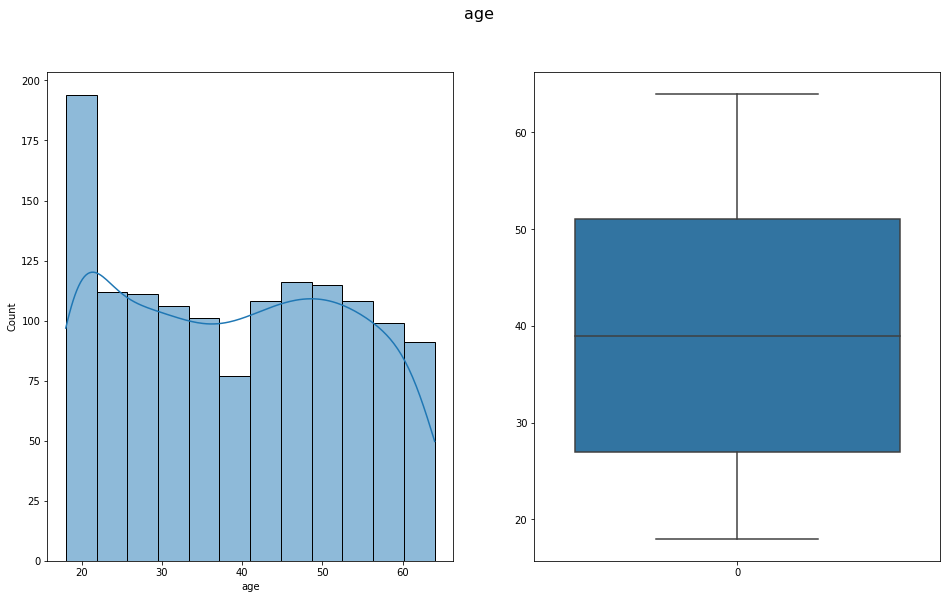

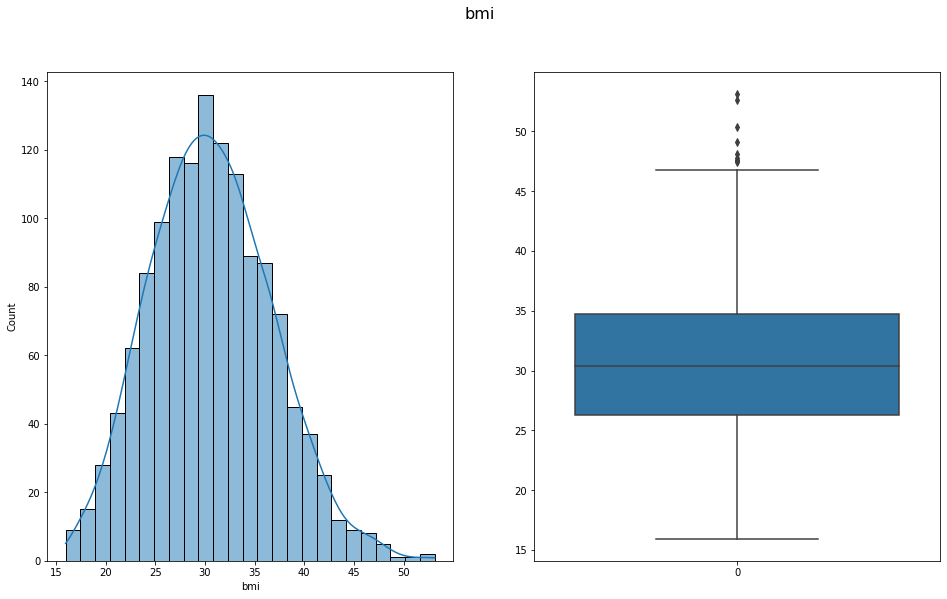

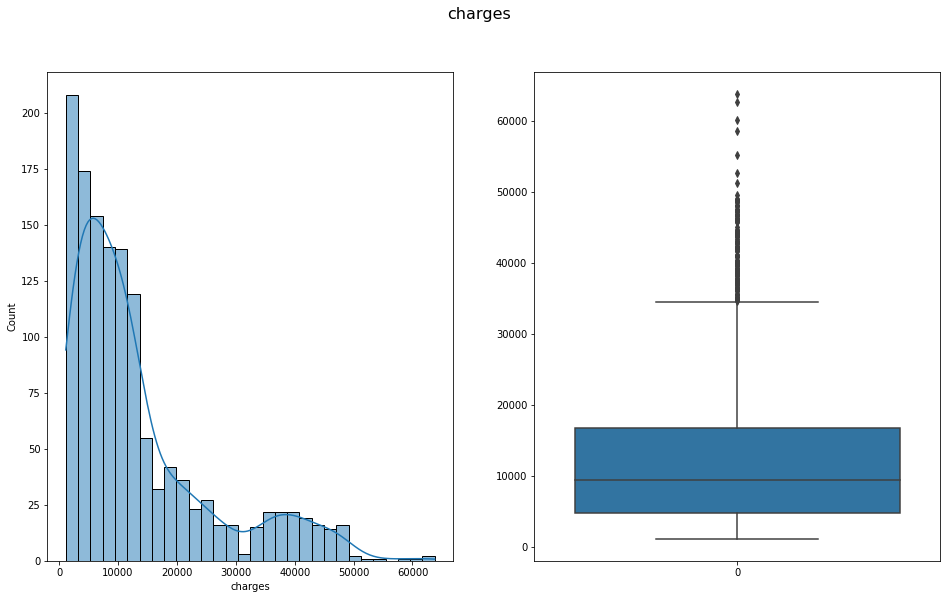

In [5]:
# Distribuição variáveis continuas
float_variables = ["age","bmi","charges"]
for c in float_variables:
    fig,ax = plt.subplots(1,2,figsize=(16,9))
    sns.histplot(medical_df[c],ax=ax[0],kde=True)
    sns.boxplot(data=medical_df[c],ax=ax[1])
    fig.suptitle(c,fontsize=16)
    fig.show()

* Distribuição aproximadamente normal dos dados de bmi.
* Boa distribuição da idade das pessoas.
* Poucas pessoas pagam valores altos em tratamentos médicos.

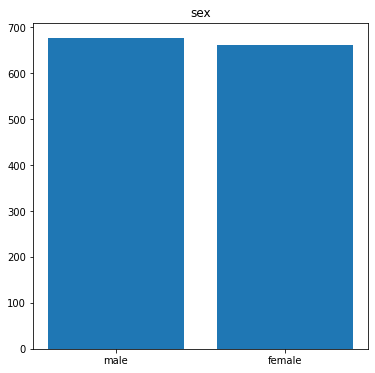

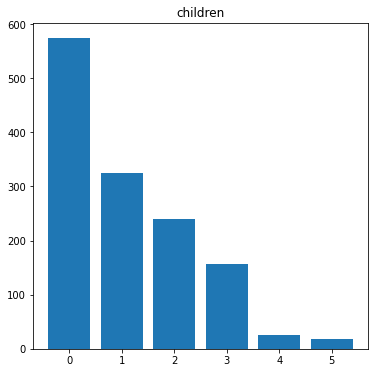

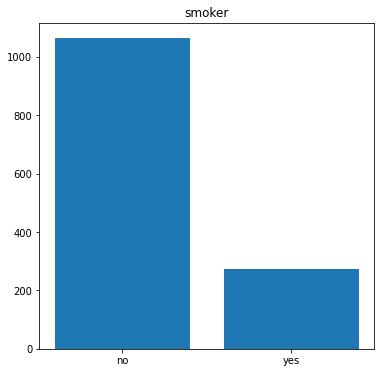

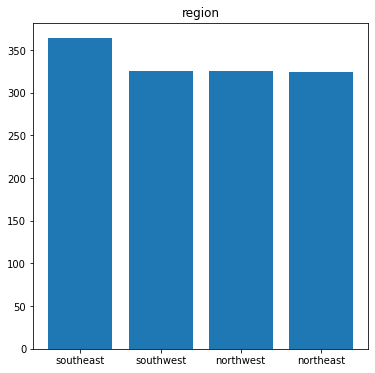

In [6]:
# Distribuição das variáveis categóricas
discrete_variables_df = medical_df[["sex","children","smoker","region"]]
for c in discrete_variables_df.columns:
    series = discrete_variables_df[c].value_counts().reset_index()
  
    fig,ax = plt.subplots(figsize=(6,6))
    ax.bar(x=series["index"].values,height=series[c].values)
    ax.set_title(c)
    fig.show()

* Distribuição praticamente igualitaria em sexo e região.
* Alta assimetria nos fumantes.

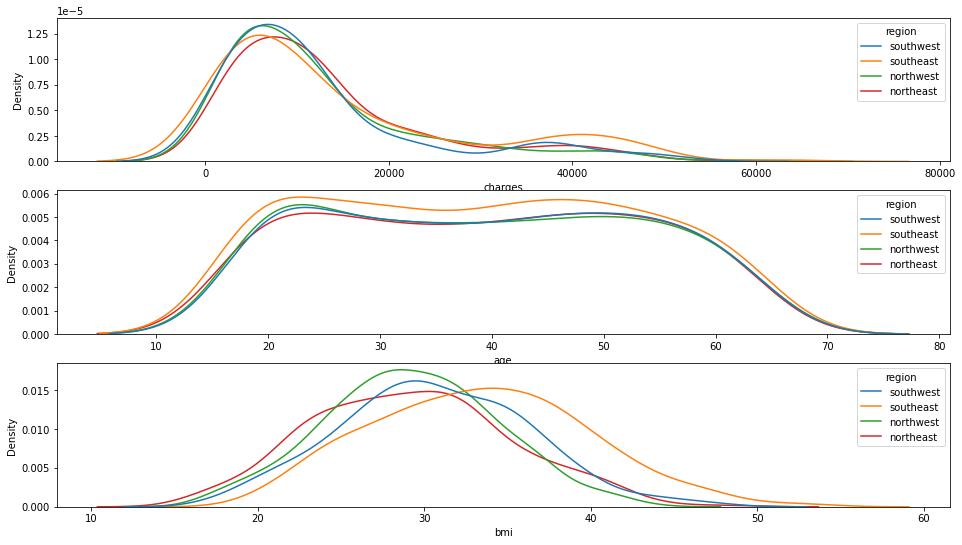

In [7]:
# Distribuição de idade e custo médico por região
fig,ax = plt.subplots(3,1,figsize = (16,9))
sns.kdeplot(data = medical_df,x = "charges",hue = 'region',ax=ax[0])
sns.kdeplot(data = medical_df,x = "age",hue = 'region',ax=ax[1])
sns.kdeplot(data = medical_df,x = "bmi",hue = 'region',ax=ax[2])
fig.show()

* Distribuições muito semelhantes nas variaveis continuas em cada região. 
* Pequeno detalhe para o IMC na região sudeste, mais elevada em relação as demais.

In [8]:
!pip install dython

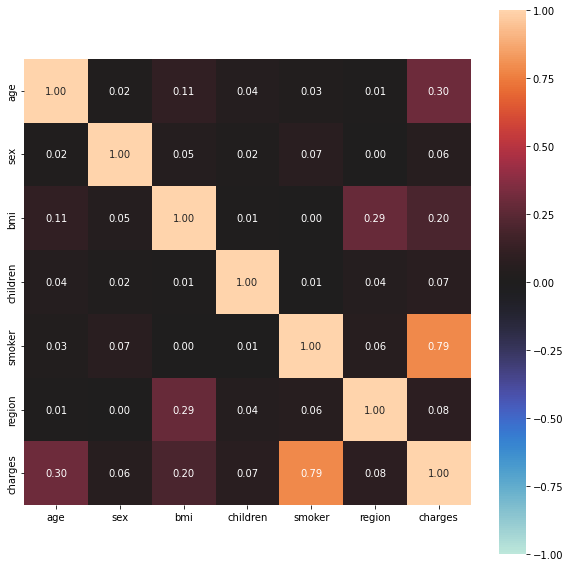

In [9]:
from dython.nominal import associations

associations(medical_df,figsize=(10,10))
fig.show()

* Alta correlação linear do custo com o fato da pessoa ser fumante.
* Baixissima correlação linear do custo com as demais variaveis categóricas.
* Como visualizado anteriormente, existe uma associação entre a região e o IMC.

# 3-) Feature Engineering

In [10]:
# ONE-HOT-ENCODING

medical_df = pd.get_dummies(medical_df,drop_first=True)
medical_df

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1,0,1,0,0
1334,18,31.920,0,2205.98080,0,0,0,0,0
1335,18,36.850,0,1629.83350,0,0,0,1,0
1336,21,25.800,0,2007.94500,0,0,0,0,1


# 4-) Feature Selection

In [11]:
medical_df.describe()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265,0.505232,0.204783,0.242900,0.272048,0.242900
std,14.049960,6.098187,1.205493,12110.011237,0.500160,0.403694,0.428995,0.445181,0.428995
min,18.000000,15.960000,0.000000,1121.873900,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,26.296250,0.000000,4740.287150,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,30.400000,1.000000,9382.033000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,51.000000,34.693750,2.000000,16639.912515,1.000000,0.000000,0.000000,1.000000,0.000000
max,64.000000,53.130000,5.000000,63770.428010,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
features = ["age","bmi","smoker_yes"]

# 5-) Models

In [43]:
seed = 10
X = medical_df.loc[:,features].values
y = medical_df['charges'].values

print(f'Shape X: {X.shape}')
print(f'Shape y: {y.shape}')

Shape X: (1338, 3)
Shape y: (1338,)


In [44]:
X_training,X_test,y_training,y_test = train_test_split(X,y,random_state=seed,test_size=0.1)

X_train,X_val,y_train,y_val = train_test_split(X_training,y_training,random_state=seed,test_size=0.25)

print(f'Shape X train: {X_train.shape}')
print(f'Shape y train: {y_train.shape}')

print(f'Shape X val: {X_val.shape}')
print(f'Shape y val: {y_train.shape}')

Shape X train: (903, 3)
Shape y train: (903,)
Shape X val: (301, 3)
Shape y val: (903,)


5.1-) Linear Regression

In [29]:
linreg = LinearRegression().fit(X_train,y_train)

print(f'Score para o treino da regressão linear:{linreg.score(X_train,y_train):.3f}')
print(f'Score para a validação da regressão linear:{linreg.score(X_val,y_val):.3f}')

Score para o treino da regressão linear:0.733
Score para a validação da regressão linear:0.811


5.2-) Random Forest

In [22]:
rf = RandomForestRegressor()

params = {"max_depth":[2,5,7,10,15,20],"n_estimators":[10,25,50,100],"min_samples_split":[2,5,10,15,25,50]}


grid_search_rf = GridSearchCV(rf,params)
grid_search_rf.fit(X_train,y_train)



Score para o treino do Random Forest:0.871
Score para a validação do Random Forest:0.916


In [30]:
rf.set_params(n_estimators = grid_search_rf.best_params_['n_estimators'],max_depth = grid_search_rf.best_params_["max_depth"],min_samples_split = grid_search_rf.best_params_["min_samples_split"])
rf.fit(X_train,y_train)

print(f'Score para o treino do Random Forest:{rf.score(X_train,y_train):.3f}')
print(f'Score para a validação do Random Forest:{rf.score(X_val,y_val):.3f}')

Score para o treino do Random Forest:0.871
Score para a validação do Random Forest:0.915


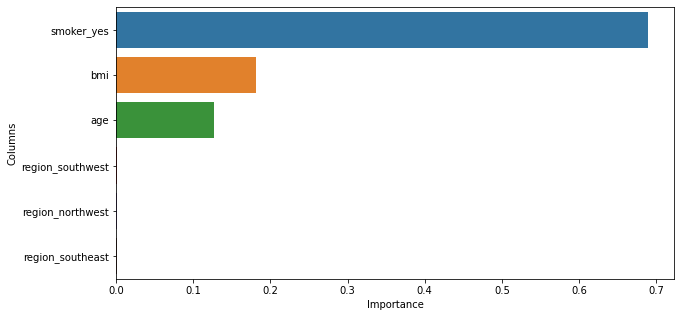

In [41]:
feature_importance_df = pd.DataFrame({'Columns':features,'Importance':rf.feature_importances_}).sort_values(by='Importance',ascending=False)

fig,ax = plt.subplots(figsize=(10,5))
sns.barplot(x  = feature_importance_df.Importance, y = feature_importance_df.Columns, palette='tab10')
fig.show()